##### Binary Classification Using Keras
Problem: Booking status is canceled or not

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Train Loss: 0.44 , Train Accuracy: 0.8
Test Loss: 0.44 , Test Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      5150
           1       0.75      0.72      0.74      3270

    accuracy                           0.80      8420
   macro avg       0.79      0.79      0.79      8420
weighted avg       0.80      0.80      0.80      8420



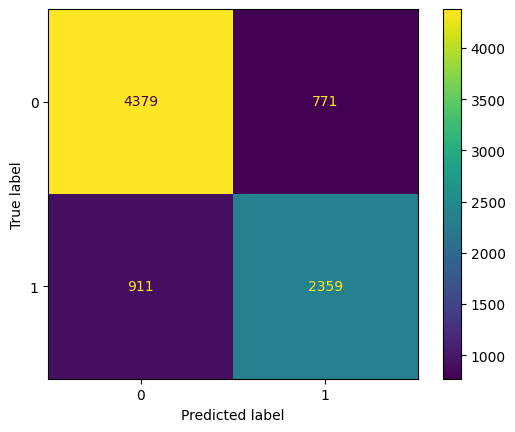

In [1]:
from warnings import filterwarnings; filterwarnings('ignore')

# Step-1: Data Ingestion
#-----------------------

import pandas as pd
df = pd.read_csv('booking_train.csv')
df.head(3)

# Step-2: Data Quality Checks
#----------------------------

duplicate_count = df.duplicated().sum()
duplicate_count
null_values = df.isna().sum().sum()
null_values

# Step-3: Separate X and Y
#-------------------------

X = df.drop(columns=["id", "booking_status"]); Y = df['booking_status']

# Step-4: Train Test Split
#-------------------------

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step-5: Apply Preprocessing on X
#---------------------------------

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = X.select_dtypes(include='number').columns
num_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

pre = ColumnTransformer([('num', num_pipe, num_cols)]).set_output(transform='pandas')
pre.fit(xtrain)

xtrain_pre = pre.transform(xtrain); xtest_pre = pre.transform(xtest)

# Step-5: Building Neural Network Model
#--------------------------------------

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

model = Sequential(
    [
        Input( shape=(xtrain_pre.shape[1], ) ), Dense(32, activation='relu'),
        Dropout(0.3), Dense(16, activation='relu'), Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(patience=5, restore_best_weights=True)

seq_model = model.fit(xtrain_pre, ytrain, validation_split= 0.2, epochs=100, callbacks=[es], verbose=False) 

# Step-6: Evaluate Model
#-----------------------

train_loss, train_acc = model.evaluate(xtrain_pre, ytrain, verbose=False)
print('Train Loss:', round(train_loss, 2), ', Train Accuracy:', round(train_acc, 2))

test_loss, test_acc = model.evaluate(xtest_pre, ytest, verbose=False)
print('Test Loss:', round(test_loss, 2), ', Test Accuracy:', round(test_acc, 2))

ytest_prob = model.predict(xtest_pre, verbose=False)
ytest_pred = [1 if prob >= 0.5 else 0 for prob in ytest_prob]

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(ytest, ytest_pred)
from sklearn.metrics import classification_report
print(classification_report(ytest, ytest_pred))

# Step-7: Out Of Sample Prediction
#---------------------------------

xnew = pd.read_csv('booking_test.csv')
xnew2 = xnew.drop(columns=['id'])
xnew_pre = pre.transform(xnew2)

probs = model.predict(xnew_pre, verbose=False)
preds = [1 if prob > 0.5 else 0 for prob in probs]

res = xnew[['id']]
res['loan_status'] = preds
res['probability'] = probs.round(4)

res.to_csv('Loan_pred.csv')


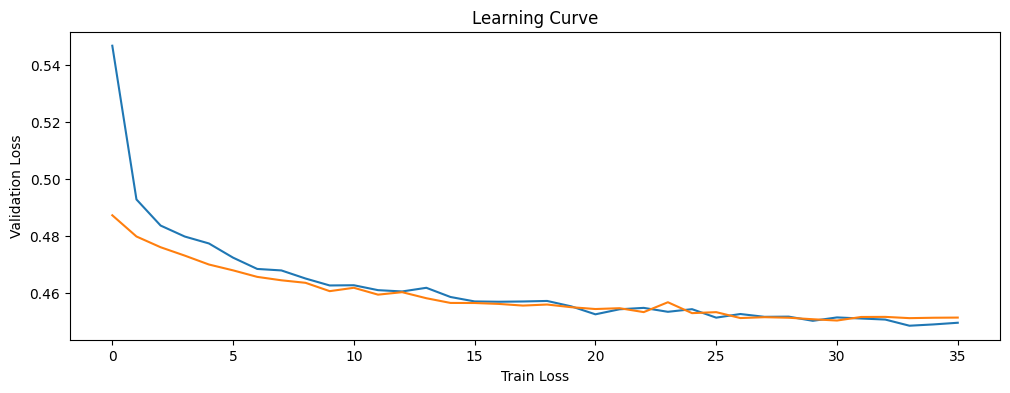

In [2]:
# Plot Learning Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.xlabel('Train Loss')
plt.ylabel('Validation Loss')
plt.title('Learning Curve')
plt.plot(seq_model.history['loss'], label='Trainloss')
plt.plot(seq_model.history['val_loss'], label='Val Loss')
plt.time
plt.show()


